In [1]:
pip install tensorflow

In [2]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.8 MB/s eta 0:00:00


In [3]:
pip install Pillow

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import cv2
import seaborn as sns
import pydicom
import pandas as pd
import random
from tensorflow.keras.utils import to_categorical

In [5]:
from PIL import Image

In [6]:
import zipfile

#### Unzip files

In [7]:
!unzip /content/SCD_IMAGES_05.zip

Streaming output truncated to the last 5000 lines.
  inflating: SCD0004201/CINELAX_303/IM-0005-0118.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0119.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0120.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0121.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0122.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0123.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0124.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0125.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0126.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0127.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0128.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0129.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0130.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0131.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0132.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0133.dcm  
  inflating: SCD0004201/CINELAX_303/IM-0005-0134.dcm  
  inflating: S

In [8]:
!unzip /content/SCD_IMAGES_01.zip

Streaming output truncated to the last 5000 lines.
  inflating: SCD0000501/CINESAX_6/IM-0005-0192.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0193.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0194.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0195.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0196.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0197.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0198.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0199.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0200.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0201.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0202.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0203.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0204.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0205.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0206.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0207.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0208.dcm  
  inflating: SCD0000501/CINESAX_6/IM-0005-0209.d

In [9]:
!unzip /content/SCD_IMAGES_03.zip

Streaming output truncated to the last 5000 lines.
  inflating: SCD0002601/CINELAX_304/IM-0005-0034.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0035.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0036.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0037.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0038.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0039.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0040.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0041.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0042.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0043.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0044.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0045.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0046.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0047.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0048.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0049.dcm  
  inflating: SCD0002601/CINELAX_304/IM-0005-0050.dcm  
  inflating: S

#### Pre-process images (adjust sizing, convert to JPEG)

Pre-process images and use supplemental csv file with patient data to categorize images by pathologies: heart failure with infarction, heart failure without infarction, hypertrophy, normal

In [10]:
# Map labels in CSV file
def category_mapping(csv_file):
    mapping = {}
    df = pd.read_csv(csv_file)

    for _, row in df.iterrows():
      patient_id = row["PatientID"]
      pathology = row["Pathology"]

      if 'Heart failure with infarct' in pathology:
        mapping[patient_id] = "HF-I"
      elif 'Heart failure without infarct' in pathology:
        mapping[patient_id] = "HF"
      elif 'Hypertrophy' in pathology:
        mapping[patient_id] = "HYP"
      elif 'Normal' in pathology:
        mapping[patient_id] = "N"
    return mapping

In [11]:
csv_file = "/content/scd_patientdata.csv"
patient_category_map = category_mapping(csv_file)

In [12]:
categories = ["HF-I", "HF", "HYP", "N"]
category_map = {category: idx for idx, category in enumerate(categories)}

In [13]:
# Process images
def process_dicom(dicom_root, image_size=(224, 224), output_folder="/content/output_jpegs"):
    images = []
    labels = []

    os.makedirs(output_folder, exist_ok=True)

    for root, dirs, files in os.walk(dicom_root):
        if not files:
            continue

        parent_folder_name = os.path.basename(os.path.dirname(root))

        if parent_folder_name not in patient_category_map:
            print(f"Skipping folder {parent_folder_name}: No category mapping found.")
            continue

        category = patient_category_map[parent_folder_name]
        label = category_map[category]

        for file in files:
            if file.endswith(".dcm"):
                file_path = os.path.join(root, file)
                try:
                    dicom = pydicom.dcmread(file_path)

                    if hasattr(dicom, "pixel_array"):
                        image = dicom.pixel_array

                        resized_image = cv2.resize(image, image_size)
                        img = np.clip(resized_image, 0, 255).astype(np.uint8)

                        save_subfolder = os.path.join(output_folder, category)
                        os.makedirs(save_subfolder, exist_ok=True)

                        filename = file.replace(".dcm", ".jpg")
                        save_path = os.path.join(save_subfolder, filename)
                        Image.fromarray(img).convert("L").save(save_path)

                        images.append(img)
                        labels.append(label)
                    else:
                        print(f"Skipping {file_path}: No pixel data found")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    if not images:
        print("No images were processed.")
        return [], []

    print(f"Processed {len(images)} images.")
    return np.array(images).reshape(-1, 224, 224, 1), np.array(labels)

In [14]:
images_1, labels_1 = process_dicom("/content/Heart Files_1")

Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004301
Processing folder: SCD0004201
Processing folder: SCD0004201
Processing

In [15]:
print(f"Number of images: {len(images_1)}")
print(f"Number of labels: {len(labels_1)}")

Number of images: 7317
Number of labels: 7317


In [16]:
from collections import Counter
label_counts = Counter(labels_1)
for category, count in label_counts.items():
    print(f"{categories[category]}: {count}")

N: 7317


In [17]:
images_2, labels_2 = process_dicom("/content/Heart Files_2")

Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000501
Processing folder: SCD0000701
Processing folder: SCD0000701
Processing

In [18]:
print(f"Number of images: {len(images_2)}")
print(f"Number of labels: {len(labels_2)}")

Number of images: 9144
Number of labels: 9144


In [19]:
from collections import Counter
label_counts = Counter(labels_2)
for category, count in label_counts.items():
    print(f"{categories[category]}: {count}")

HF-I: 9144


In [20]:
images_3, labels_3 = process_dicom("/content/Heart Files_3")

Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002901
Processing folder: SCD0002601
Processing

In [21]:
print(f"Number of images: {len(images_3)}")
print(f"Number of labels: {len(labels_3)}")

from collections import Counter
label_counts = Counter(labels_3)
for category, count in label_counts.items():
    print(f"{categories[category]}: {count}")

Number of images: 11858
Number of labels: 11858
HYP: 5894
HF: 5964


In [29]:
# Merge all image and label samples
images = np.concatenate([images_1, images_2, images_3], axis=0)
labels = np.concatenate([labels_1, labels_2, labels_3], axis=0)

num_classes = len(category_map)
labels = to_categorical(labels, num_classes=num_classes)

labels_int = np.argmax(labels, axis=1)

# Reduce sample size to 2,500 per category to reduce overfitting
image_category = 10_000 // num_classes

image_samples = []
label_samples = []

# Normalize images
for category in range(num_classes):
    category_indices = np.where(labels_int == category)[0]
    sampled_indices = random.sample(list(category_indices), min(image_category, len(category_indices)))
    image_samples.append(images[sampled_indices])
    label_samples.extend(labels[sampled_indices])

image_samples = np.vstack(image_samples).astype("float32") / 255.0
label_samples = np.vstack(label_samples)

In [38]:
# Reshape images for model
image_samples = image_samples.reshape(-1, 224, 224, 1)

#### Display image from each category

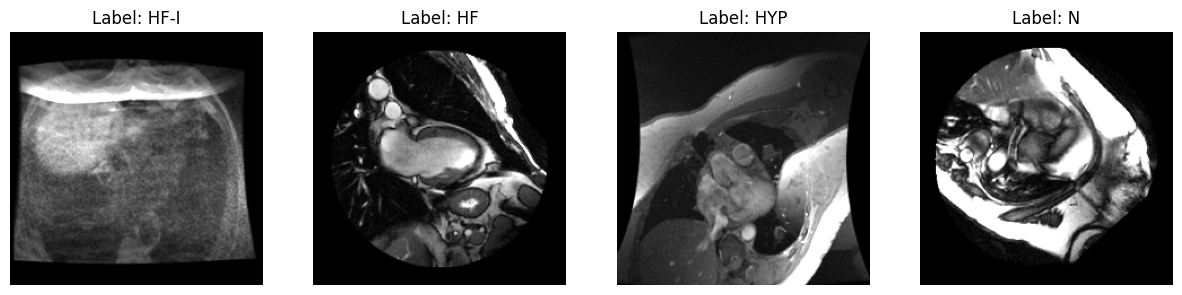

In [35]:
category_images = {category: [] for category in categories}

for img, label in zip(image_samples, label_samples):
    label_index = np.argmax(label)
    category_images[categories[label_index]].append(img)

num_categories = len(categories)
fig, axes = plt.subplots(1, num_categories, figsize=(15, 5))

if num_categories == 1:
    axes = [axes]

for i, category in enumerate(categories):
    img = category_images[category][0]
    img = np.squeeze(img)

    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Label: {category}")

plt.show()

### Build Neural Network

In [36]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, UpSampling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Build Model

In [39]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,900 (42.61 MB)

 Trainable params: 11,168,900 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Train Model

In [41]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(image_samples, label_samples, test_size=0.2, random_state=42)

In [43]:
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.6217 - loss: 0.8774 - val_accuracy: 0.9365 - val_loss: 0.1849
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.9241 - loss: 0.2143 - val_accuracy: 0.9560 - val_loss: 0.1304
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9474 - loss: 0.1429 - val_accuracy: 0.9660 - val_loss: 0.1088
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9612 - loss: 0.1043 - val_accuracy: 0.9675 - val_loss: 0.0998
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9671 - loss: 0.0847 - val_accuracy: 0.9660 - val_loss: 0.1112
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9695 - loss: 0.0866 - val_accuracy: 0.9725 - val_loss: 0.1103
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9781 - loss: 0.0624 - val_accuracy: 0.9730 - val_loss: 0.1008
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9766 -

In [44]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9814 - loss: 0.0906
Test Loss: 0.0977
Test Accuracy: 97.90%


#### Save model to Google drive

In [45]:
from google.colab import drive
model.save('/content/drive/MyDrive/heart_model.h5')

### Predict

In [46]:
predictions_vector = model.predict(X_test)
predictions = np.argmax(predictions_vector, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


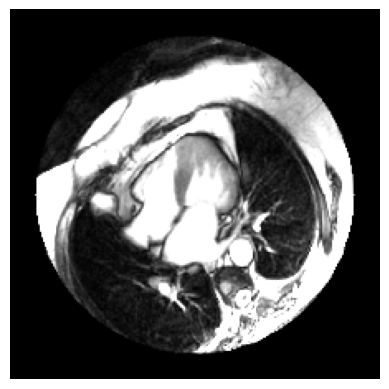

The predicted label is: HF-I
The true label is: HF-I


In [64]:
predicted_label_name = categories[predictions[9]]
true_label = np.argmax(y_test[9])
true_label_name = categories[true_label]

plt.imshow(X_test[0], cmap='gray')
plt.axis('off')
plt.show()
print("The predicted label is:", predicted_label_name)
print("The true label is:", true_label_name)